In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# データをダウンロードして分割
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 訓練データの最小値と最大値を計算
scaler = MinMaxScaler().fit(X_train)

# 訓練データをスケール変換
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# SMVをスケール変換したデータで訓練
svm.fit(X_train_scaled, y_train)
# テストデータをスケール変換して、それを用いて評価
X_test_scaled = scaler.transform(X_test)
print(f"Test score: {svm.score(X_test_scaled, y_test)}")

Test score: 0.951048951048951


In [2]:
from sklearn.model_selection import GridSearchCV
# 説明用のコードのため、こう書かないように。
# スケール変換する際に、テストデータとなった部分に含まれている情報を使ってしまっている。
# 交差検証で用いるテストデータとして使う部分は、訓練データ・セットの一部であり、データの正しいスケールを決めるために
# 訓練データセット全体の情報を使っているからだ、
# このようなデータはモデルに対してなったく新しいデータとは本質的に異なる
# まったく新しいデータを観測した場合、そのデータは訓練セット

param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"Best cross-validation accuracy: {grid.best_score_}")
print(f"Best set score: {grid.score(X_test_scaled, y_test)}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation accuracy: 0.9812206572769953
Best set score: 0.972027972027972
Best parameters: {'C': 1, 'gamma': 1}


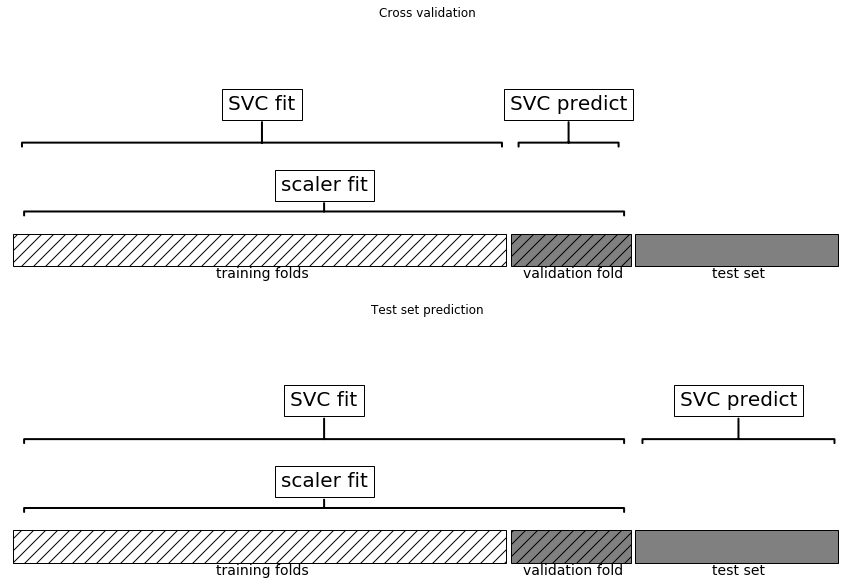

In [4]:
import mglearn
from matplotlib import pyplot as plt

mglearn.plots.plot_improper_processing()

In [3]:
# この場合、交差検証のためのデータ分割を行う必要がある
# Pipleineを用いる（ここではgrid search を行わない）
from sklearn.pipeline import Pipeline

# テストデータをscaler変換し、SVMのscoreメソッドを変換されたデータで呼び出す.
# パイプラインを単独のEstimatorとして使うことができる
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])
pipe.fit(X_train, y_train)
print(f"Test score: {pipe.score(X_test, y_test)}")

Test score: 0.951048951048951


In [4]:
# パイプラインを用いたグリッドサーチ
# パラメータグリッドを定義する文法として。ステップ名+ __ + パラメータ名 を使う
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10 , 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f"Best cross-validation accuracy: {grid.best_score_}")
print(f"Test set score: {grid.score(X_test, y_test)}")
print(f"Best parameters: {grid.best_params_}")
# 以前に行ったGridSearchと異なり、交差検証の個々の分割に対して、訓練用のパートのみを対象としてMinMaxScalerをfitし直すので
# テスト用のパートから情報がパラメータサーチに漏れることはない

Best cross-validation accuracy: 0.9812206572769953
Test set score: 0.972027972027972
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


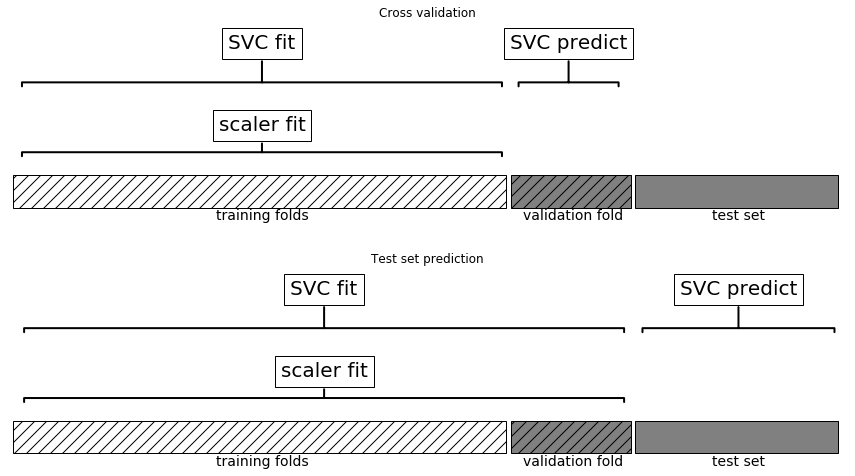

In [7]:
mglearn.plots.plot_proper_processing()

In [5]:
# パイプラインは前処理とクラス分類だけではなく、任意の個数のEstimatorを連結できる
# 自前で作ることもできる
def  fit(self, X, y):
    X_transfomred = X
    for name, estimator in self.steps[:-1]:
        # 最後のステップ以外で、fitとtransformを順に実行する
        X_transformed = estimator.fit_transform(X_transfomred, y)
    # 最後のステップでfit
    self.steps[-1][1].fit(X_transfomred, y)
    return self

def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 最後のステップ以外で、transformを順に実行
        X_transformed = step[1].transform(X_transfomred)
    #最後のステップではpredict
    return self.steps[-1][1].predict(X_transfomred)
    

In [7]:
# make_piplineによる簡便なパイプライン
from sklearn.pipeline import make_pipeline
# 標準の文法
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
# 短縮文法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

print(f"Pipeline steps: {pipe_short.steps}")

Pipeline steps: [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print(f"Pipline steps: {pipe.steps}")

Pipline steps: [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [9]:
# パイプラインに含まれる各ステップの属性を見たい場合がある
# named_stepを用いてアクセスする
# canceer データセットを用いて、定義しておいたパイプラインを訓練
pipe.fit(cancer.data)
# pcaステップ2
components = pipe.named_steps['pca'].components_
print(f"components.shape: {components.shape}")

components.shape: (2, 30)


In [12]:
# グリッドサーチの属性にアクセスする
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

# パラメータグリッドを作る
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Logistic regression coefficients: {grid.best_estimator_.named_steps['logisticregression'].coef_}")

Best estimator: Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic regression coefficients: [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


In [17]:
# 機械学習ワークフローのすべてのステップを1つのEstimatorにカプセル化することができる
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap='viridis')
plt.xlabel('ridge__alpha')
plt.label('polynomialfeatures__degree')
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()
plt.show()

print(f"Best prameters: {grid.best_params_}")

KeyboardInterrupt: 

In [20]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None], 'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 , 100], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             {'classifier': [RandomForestClassifier(n_estimators=100)], 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_}")
print(f"Test-set score: {grid.score(X_test, y_test)}")

Best params: {'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}
Best cross-validation score: 0.9859154929577465
Test-set score: 0.9790209790209791
